In [ ]:
import json, pathlib, pandas as pd

# ---------- paths ----------
orig_path   = "/Users/michaelkan/Desktop/reasoning_model_test/custom_cot/utils/mitigation/LandManager_findings.json"
v1_path     = "/Users/michaelkan/Desktop/reasoning_model_test/custom_cot/logs/mitigation/adjustments/audit_agent_mitigation.json"
cot_path    = "/Users/michaelkan/Desktop/reasoning_model_test/custom_cot/logs/mitigation/adjustments/cot_schema2_2_gpt-4.1-2025-04-14_dynamicRB_html_adjustments.json"
# ---------- load ----------
original = {f["index"]: f for f in json.load(open(orig_path))}
mit_v1   = {f["index"]: f for f in json.load(open(v1_path))}
mit_cot  = {f["index"]: f for f in json.load(open(cot_path))}

severity_scale = ["high", "medium", "low", "info", "best practices"]

def norm(s):
    return s.lower().strip()

def delta(old, new):
    old_l, new_l = norm(old), norm(new)
    if old_l == new_l:
        return "same"
    # if unknown value, treat as same
    if old_l not in severity_scale or new_l not in severity_scale:
        return "same"
    return "up" if severity_scale.index(new_l) < severity_scale.index(old_l) else "down"

rows = []
for idx, base in original.items():
    row = {
        "index": idx,
        "orig_severity": norm(base["Severity"]),
    }

    # ---------- v1 critic ----------
    v1 = mit_v1.get(idx, {})
    v1_sev = norm(v1.get("severity", row["orig_severity"]))
    row.update({
        "v1_severity": v1_sev,
        "v1_false_positive": v1.get("should_be_removed", False),
        "v1_severity_delta": delta(row["orig_severity"], v1_sev),
    })

    # ---------- CoT critic ----------
    cot = mit_cot.get(idx, {})
    cot_sev = norm(cot.get("severity", row["orig_severity"]))
    row.update({
        "cot_severity": cot_sev,
        "cot_false_positive": cot.get("should_be_removed", False),
        "cot_severity_delta": delta(row["orig_severity"], cot_sev),
    })

    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("diff_report_html.csv", index=False)

diff_report.csv saved


In [2]:
import pandas as pd

df_dynamic = pd.read_csv("diff_report_dynamic.csv")
df_html = pd.read_csv("diff_report_html.csv")
df_demo = pd.read_csv("diff_report_demo.csv")
df_dynamic.head()

,index,orig_severity,v1_severity,v1_false_positive,v1_severity_delta,cot_severity,cot_false_positive,cot_severity_delta
0,0,high,low,True,down,high,False,same
1,1,medium,medium,False,same,medium,False,same
2,2,low,low,False,same,medium,False,up
3,3,low,low,False,same,medium,False,up
4,4,low,medium,False,up,medium,False,up


# CoT

df_dynamic severity change: cot_severity_delta
same    49
up      23
down    14
Name: count, dtype: int64
df_demo severity change: cot_severity_delta
same    46
up      28
down    12
Name: count, dtype: int64
df_html severity change: cot_severity_delta
same    48
up      20
down    18
Name: count, dtype: int64


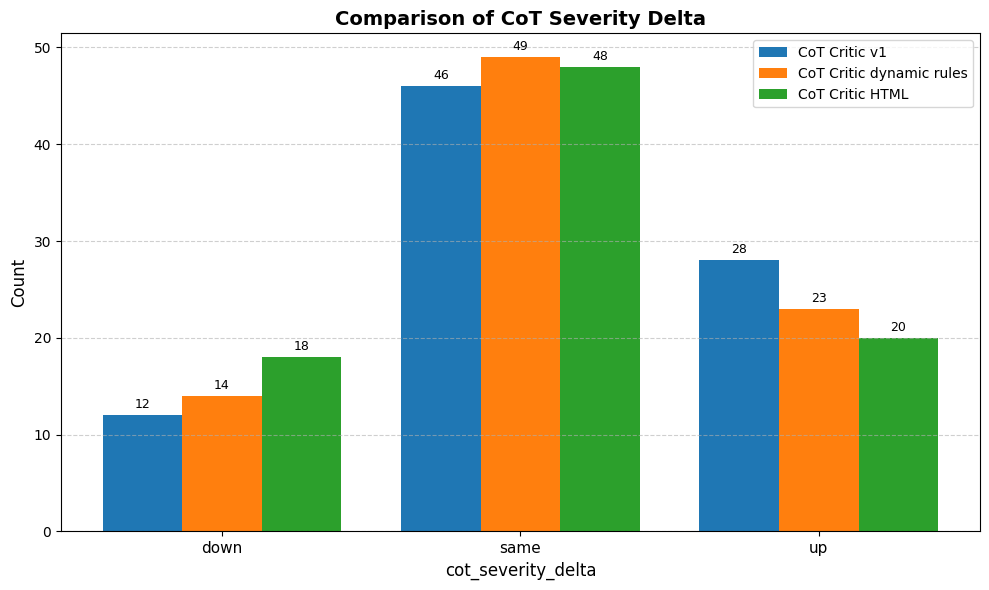

In [ ]:
from utils import plot_grouped_bar_counts

counts = df_dynamic["cot_severity_delta"].value_counts()
counts_demo = df_demo["cot_severity_delta"].value_counts()
counts_html = df_html["cot_severity_delta"].value_counts()
print(f"df_dynamic severity change: {counts}")
print(f"df_demo severity change: {counts_demo}")
print(f"df_html severity change: {counts_html}")

plot_grouped_bar_counts(dfs=[df_demo, df_dynamic, df_html],
                        column="cot_severity_delta", 
                        labels=["CoT Critic v1", "CoT Critic dynamic rules", "CoT Critic HTML"],
                        title="Comparison of CoT Severity Delta"
                        )

df_dynamic false positive: cot_false_positive
False    79
True      7
Name: count, dtype: int64
df_demo false positive: cot_false_positive
False    79
True      7
Name: count, dtype: int64
df_html false positive: cot_false_positive
False    79
True      7
Name: count, dtype: int64


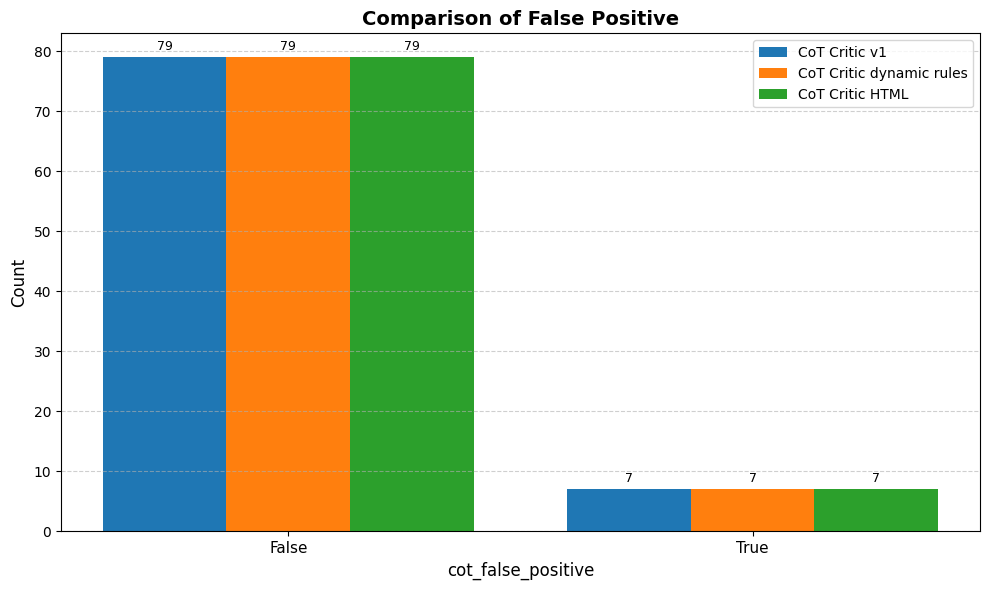

In [ ]:
from utils import plot_grouped_bar_counts

counts = df_dynamic["cot_false_positive"].value_counts()
counts_demo = df_demo["cot_false_positive"].value_counts()
counts_html = df_html["cot_false_positive"].value_counts()
print(f"df_dynamic false positive: {counts}")
print(f"df_demo false positive: {counts}")
print(f"df_html false positive: {counts_html}")


plot_grouped_bar_counts(dfs=[df_demo, df_dynamic, df_html],
                        column="cot_false_positive", 
                        labels=["CoT Critic v1", "CoT Critic dynamic rules", "CoT Critic HTML"],
                        title="Comparison of False Positives"
                        )

# AuditAgent Critic

v1_false_positive: v1_false_positive
False    71
True     15
Name: count, dtype: int64


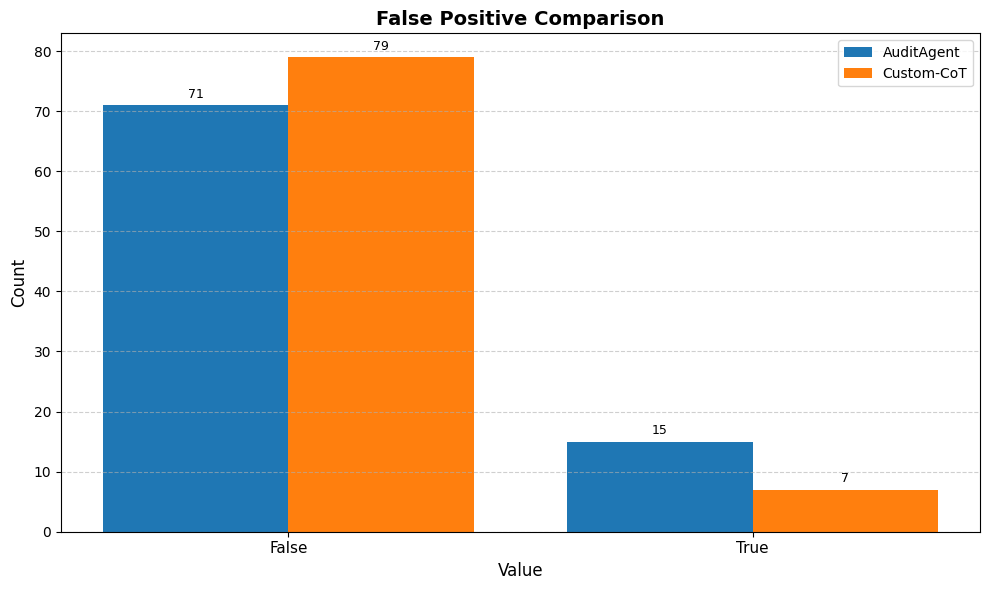

In [4]:
from utils import plot_grouped_bar_from_columns

counts = df_dynamic["v1_false_positive"].value_counts()
print(f"v1_false_positive: {counts}")

plot_grouped_bar_from_columns(
    df=df_html,
    columns=["v1_false_positive", "cot_false_positive"],
    labels=["AuditAgent", "Custom-CoT"],
    title="False Positive Comparison"
)

v1_severity_delta: v1_severity_delta
same    84
down     1
up       1
Name: count, dtype: int64


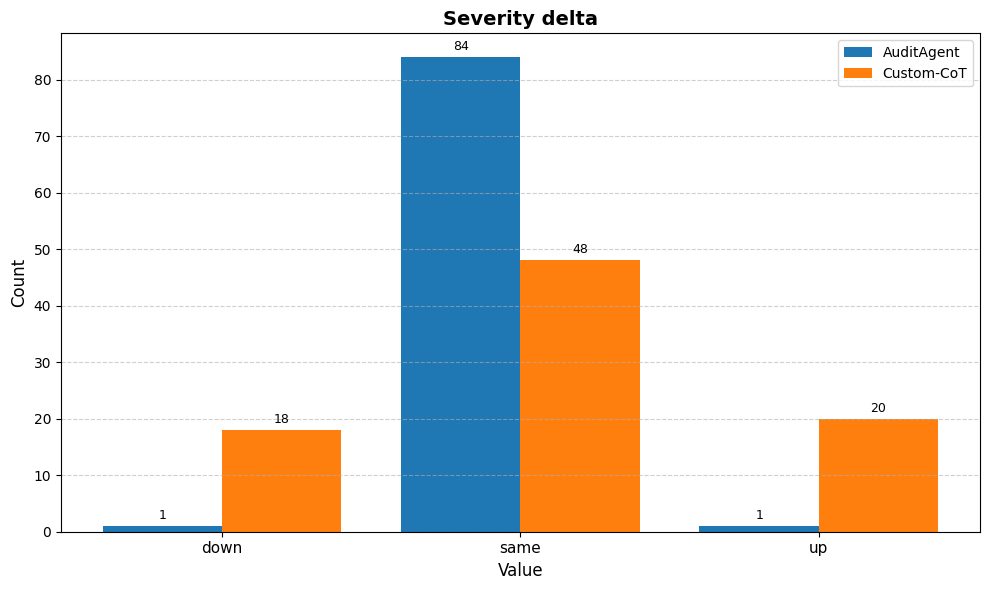

In [6]:
from utils import plot_grouped_bar_from_columns

counts = df_html["v1_severity_delta"].value_counts()
print(f"v1_severity_delta: {counts}")

plot_grouped_bar_from_columns(
    df=df_html,
    columns=["v1_severity_delta", "cot_severity_delta"],
    labels=["AuditAgent", "Custom-CoT"],
    title="Severity delta"
)